# Chargement jeu de données

In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/My Drive/result_requetes.csv')

df["city"]=pd.Categorical(df["city"],ordered=False)
df["language"]=pd.Categorical(df["language"],ordered=False)
df["group"]=pd.Categorical(df["group"],ordered=False)
df["brand"]=pd.Categorical(df["brand"],ordered=False)

df["mobile"]=pd.Categorical(df["mobile"],ordered=False)
df["parking"]=pd.Categorical(df["parking"],ordered=False)
df["pool"]=pd.Categorical(df["pool"],ordered=False)
df["children_policy"]=pd.Categorical(df["children_policy"],ordered=False)

df["hotel_id"]=pd.Categorical(df["hotel_id"],ordered=False)
df["avatar_id"]=pd.Categorical(df["avatar_id"],ordered=False)

df["price"]=pd.DataFrame(df["price"], dtype=float)


y = pd.DataFrame(df['price'])

Mounted at /content/gdrive


# Target encoder

In [ ]:
!pip install category_encoders

In [ ]:
from category_encoders import TargetEncoder
#Modele avec les features : date	nb_requete	stock	hotel_id	city	language	mobile	group	brand	children_policy
#ie sans : order_requests avatar_id parking pool

X = df.drop(columns=['price',"stock","date","nb_requete","order_requests",'avatar_id','parking','pool'])
enc = TargetEncoder()
#enc.fit(X,y)

Xenc=enc.fit_transform(X,y)

dataDum=pd.DataFrame(Xenc, columns= enc.get_feature_names())

dataQuant = df[["date","nb_requete","stock"]]

dfC = pd.concat([dataQuant,dataDum],axis=1)
dfC.head()

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


,date,nb_requete,stock,hotel_id,city,language,mobile,group,brand,children_policy
0,30,1,58,136.571429,146.083588,150.162002,159.736406,95.137956,95.137956,155.7596
1,30,1,97,199.828571,146.083588,150.162002,159.736406,149.960742,201.414856,155.7596
2,30,1,21,102.551724,146.083588,150.162002,159.736406,95.137956,95.137956,155.7596
3,30,1,74,175.828571,146.083588,150.162002,159.736406,225.506291,199.501928,155.7596
4,30,1,21,72.485714,146.083588,150.162002,159.736406,149.960742,75.949469,155.7596


# RF

In [ ]:
dfC.dtypes

date                 int64
nb_requete           int64
stock                int64
hotel_id           float64
city               float64
language           float64
mobile             float64
group              float64
brand              float64
children_policy    float64
dtype: object

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    dfC,
    y,
    test_size=0.2,
    random_state=42,
)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer, StandardScaler

from sklearn.ensemble import RandomForestRegressor


rf = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(max_depth=20),
)

#rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=20)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

In [ ]:
print(f'with target encoding {rf.score(X_test,y_test, pred):.4f}')

with target encoding 0.9921


In [ ]:
from joblib import dump, load
dump(rf, '/content/gdrive/My Drive/Defi_IA/rf_model_TargetEnc.joblib')

['/content/gdrive/My Drive/Defi_IA/rf_model_TargetEnc.joblib']

# Interpretabilité

### Features Importance

In [24]:
!pip install eli5 > /dev/null 2>&1

In [25]:
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import seaborn as sns

features_importance_dict = {}
#for model, name in zip([lr, rf, mlp], ['logistic regression', 'random forest', 'multi layer perceptron']):
for model, name in zip([rf], ['random forest']):
  plt.figure()
  permumtation_impor = PermutationImportance(model, random_state=0).fit(X_test, y_test)

<Figure size 432x288 with 0 Axes>

In [26]:
features_name = dfC.columns

In [27]:
features_importance = {'Feature_name':features_name, 'Importance':permumtation_impor.feature_importances_}  
features_importance = pd.DataFrame(features_importance) 
features_importance = features_importance.sort_values(['Importance'], ascending=False) 
features_importance_dict[name] = features_importance

In [28]:
features_importance[0:20]

,Feature_name,Importance
3,hotel_id,1.985553
2,stock,0.118252
0,date,0.040966
4,city,0.021319
8,brand,0.009058
5,language,0.002328
7,group,0.002144
9,children_policy,0.000424
1,nb_requete,0.000202
6,mobile,0.000095


Text(0.5, 1.0, 'random forest')

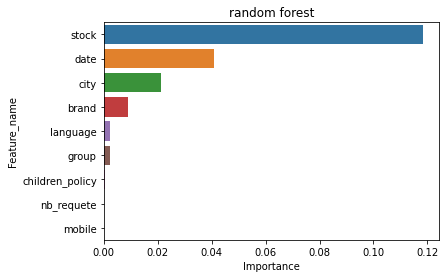

In [31]:
plt.figure()
ax = sns.barplot(x="Importance", y="Feature_name", data=features_importance[1:20])
plt.title(name)

### PDP

In [32]:
!pip install pdpbox > /dev/null 2>&1

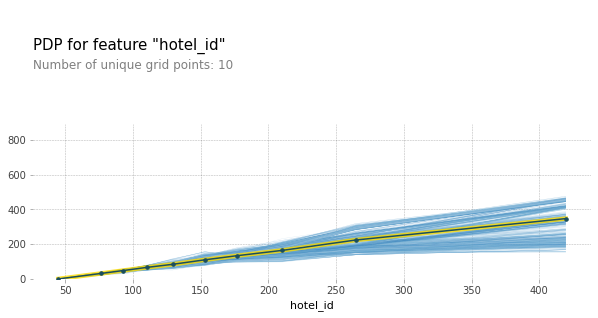

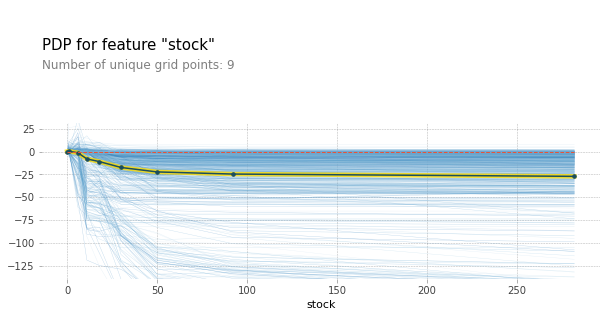

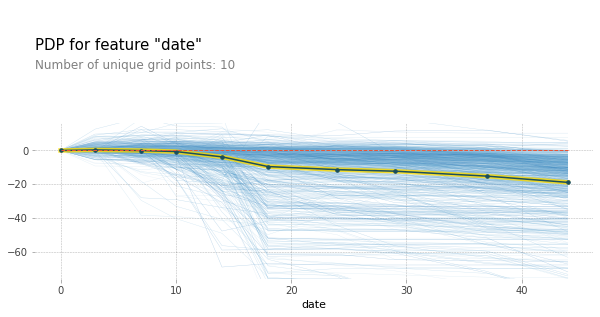

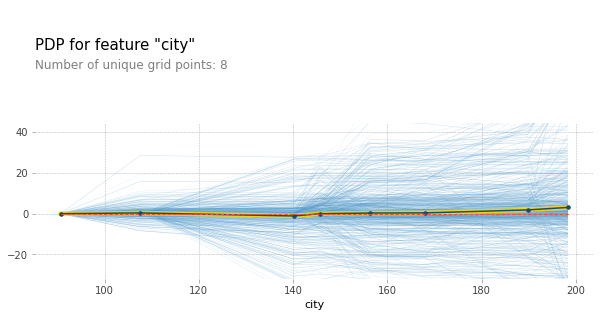

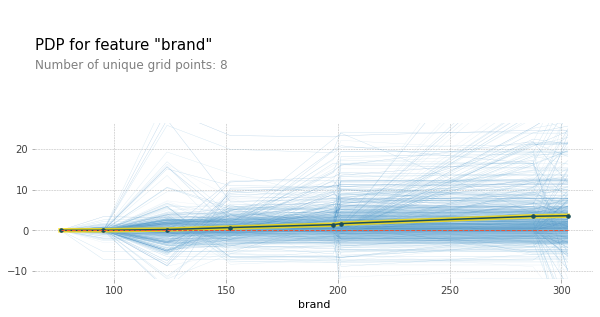

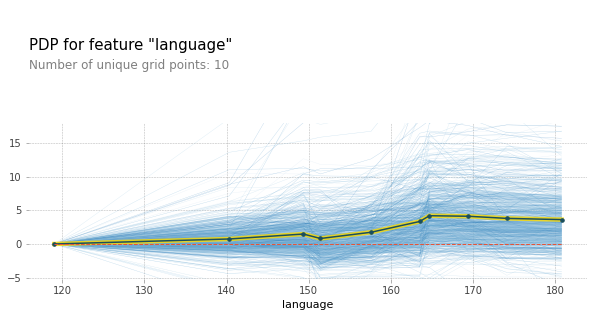

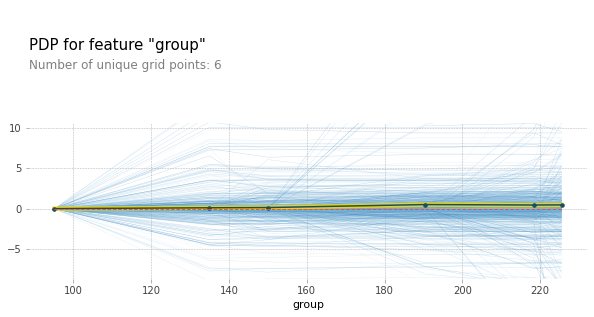

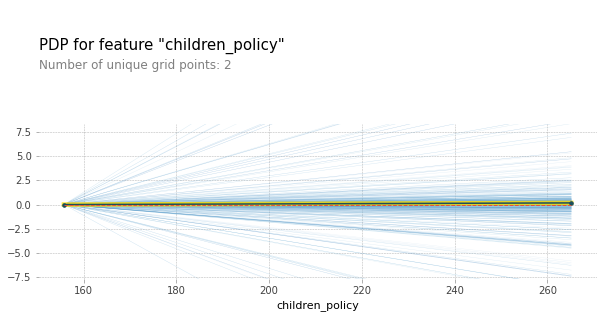

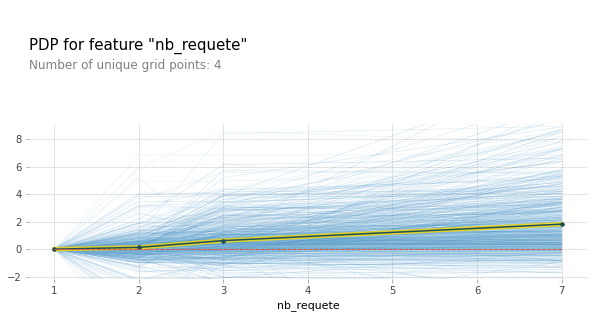

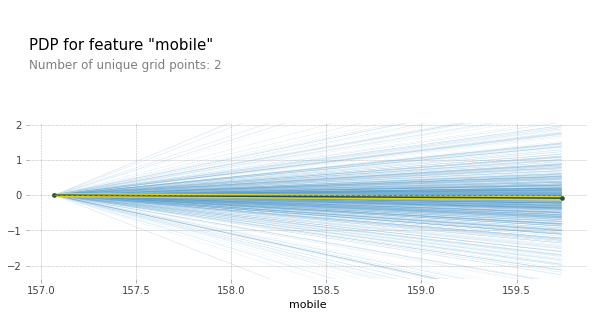

In [33]:
from pdpbox import pdp, get_dataset, info_plots
model = rf 
model_name = 'random forest'

top_10_features = features_importance_dict[model_name].Feature_name[:10].values
for i, feature in enumerate(top_10_features, 1):
  pdp_feat = pdp.pdp_isolate(model=model, dataset=X_test, model_features=features_name, feature=feature)
  pdp.pdp_plot(pdp_feat, feature, plot_lines=True, frac_to_plot=0.1, figsize=(10,5))

### SHAP

In [34]:
!pip install shap > /dev/null 2>&1

  0%|          | 0/10 [00:00<?, ?it/s]

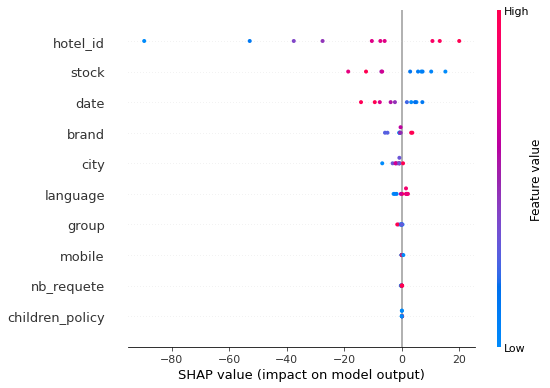

In [49]:
import shap
shap.initjs() #needed to plot results directly on the notebook

idx = 1 # index of the instance we want to explain

explainer = shap.KernelExplainer(rf.predict, X_test)
shap_values = explainer.shap_values(X_test.iloc[0:10,:]) #To speed up we just compute the shap values for 100 exemples
shap.summary_plot(shap_values, X_test.iloc[0:10,:])

### LIME

In [38]:
!pip install lime > /dev/null 2>&1

In [47]:
X_test.dtypes

date                 int64
nb_requete           int64
stock                int64
hotel_id           float64
city               float64
language           float64
mobile             float64
group              float64
brand              float64
children_policy    float64
dtype: object

In [48]:
import lime
import lime.lime_tabular

index = 0

explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, feature_names=features_name,
                                                   mode = 'regression',categorical_features =[3,4,5,6,7,8,9] )#mode="randomforest")
exp = explainer.explain_instance(X_test.iloc[index], rf.predict, num_features=10, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=True)

In [42]:
exp.predicted_value

120.74861111111112